# Inferential statistics II - Bootstrapping

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

## Medical charge data set

In [2]:
med_charges = pd.read_csv('data/insurance2.csv')

In [3]:
med_charges.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q:__ Use bootstrap sampling to estimate the same 95% confidence interval lower limit as before.

__A:__

In [20]:
# Define function to draw replicates
def bs_sample(data):
    bs = np.random.choice(data,len(data))
    return bs

In [21]:
np.random.seed(47)
N_rep = 10000

# Generate sample distribution of mean charge
sample_dist = [np.mean(bs_sample(med_charges.charges)) for i in range(N_rep)]
low = np.percentile(sample_dist,5)

print('95% CI lower limit of true average charge: ',low)

95% CI lower limit of true average charge:  12724.467921704


__Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates. Plot the histogram of values and mark the locations of the percentiles. State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.

__A:__

In [12]:
# Get bootstrap dataframe replicate
def bs_rep_df(df):
    # make a copy
    df = df.copy()
    # Get replicate from random sampling.
    bs_rep = df.sample(frac=1,replace=True)
    return bs_rep

# Get difference in standard deviations
def std_dev_diff(df):
    # make a copy
    df = df.copy()
    
    # Get the rows with and without insurance.
    x0 = df[df.insuranceclaim==0]['charges'].copy().values
    x1 = df[df.insuranceclaim==1]['charges'].copy().values
    
    # Calculate standard deviations.
    s0 = np.std(x0)
    s1 = np.std(x1)
    
    # Return the difference
    diff = s1 - s0
    return diff    

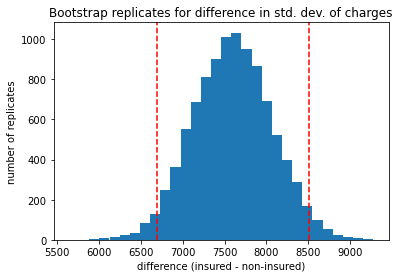

In [13]:
# Generate 10000 replicates of the difference
diff_reps = [std_dev_diff(bs_rep_df(med_charges)) for i in range(N_rep)]

conf_int = np.percentile(diff_reps,[2.5,97.5])

# Plotting histogram with marked percentiles
plt.hist(diff_reps,bins=30);
plt.xlabel('difference (insured - non-insured)');
plt.ylabel('number of replicates');
plt.title('Bootstrap replicates for difference in std. dev. of charges');
plt.axvline(conf_int[0], color='r', linestyle='--');
plt.axvline(conf_int[1], color='r', linestyle='--');

***
**<u>Null hypothesis</u>**

*Let $x_0, x_1$ denote the sets of charges for non-insured and insured patients, respectively, with their variances denoted as $s_0^2, s_1^2$. If these two groups have equal variance, then the difference in their standard deviations is zero:*

<h1><center>
$s_0^2=s_1^2 \implies s_1 - s_0 = 0$
</center></h1>

***
**<u>Alternative hypothesis</u>**

*If these two groups do not have equal variance, then there is a non-zero difference in their standard deviations:*

<h1><center>
$s_0^2 \neq s_1^2 \implies s_1 - s_0 \neq 0$
</center></h1>

***


**In this case I would likely reject the null hypothesis because the 95% confidence interval for the difference in their standard deviations does not contain zero.**

__Q:__ Perform a bootstrapped hypothesis test at the 5% significance level ($\alpha = 0.05$) to calculate the p-value of the observed difference between insurance and non-insurance charges, state your null and alternative hypotheses and whether you retain or reject the null hypothesis for the given significance level.

__A:__

***
**<u>Null hypothesis</u>**

*Let $x_0, x_1$ denote the sets of charges for non-insured and insured patients, respectively. If patients without insurance are not being charged differently than patients with insurance, then the difference in mean charge between these groups is zero:*

$D_n \equiv$ Patients with and without insurance are not charged differently

<h1><center>
$D_n \implies \bar{x_1}-\bar{x_0} = 0$
</center></h1>

***
**<u>Alternative hypothesis</u>**

*If patients without insurance are charged differently than patients with insurance, then the difference in mean charge between these groups is  not zero:*

$D_a \equiv$ Patients with and without insurance are charged differently

<h1><center>
$D_a \implies \bar{x_1}-\bar{x_0} \neq 0$
</center></h1>

***

We begin by generating bootstrap replicates under the assumption of the null hypothesis. To do this, the array of charges for both groups must be shifted such that their means are equal.

In [17]:
# Get the two arrays.
x0 = med_charges[med_charges.insuranceclaim==0]['charges'].copy().values
x1 = med_charges[med_charges.insuranceclaim==1]['charges'].copy().values

# Get the full mean charge
X_mean = np.mean(med_charges.charges)

# Calculate shifted arrays
x0_shifted = x0 - np.mean(x0) + X_mean
x1_shifted = x1 - np.mean(x1) + X_mean

# Calculate observed difference in means
obs_diff = np.mean(x1) - np.mean(x0)

In [23]:
# Define function to get replicates of difference in mean
def bs_diff_means(x_0,x_1):
    # Generate bootstrap samples of arrays
    x0_bs = bs_sample(x_0)
    x1_bs = bs_sample(x_1)
    
    # Return the difference in means
    diff = np.mean(x1_bs) - np.mean(x0_bs)
    return diff

# Generate 10,000 bootstrap replicates 
diff_reps = [bs_diff_means(x0_shifted,x1_shifted) for i in range(50000)]


# Define the alpha value
alpha = 0.05

# Calculate the p-value
p = np.sum(diff_reps >= obs_diff)/len(diff_reps)

if p >= alpha:
    print('The resultant p-value does not allow us to reject the null hypothesis.')
else:
    print('The p-value (p = {}) allows us to reject '
          'the null hypothesis for the given significance level.'.format(p))

The p-value (p = 0.0) allows us to reject the null hypothesis for the given significance level.


__Q:__ To put the above result in perspective, plot the histogram of your bootstrapped differences along with lines marking the locations of the observed difference. (Why would we plot more than one line, given that we only have one observed difference?)

__A:__ We plot more than one line for the observed difference since under the null hypothesis the probabilities of observing a positive or negative value this extreme are equally likely.

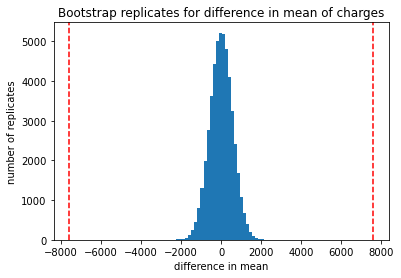

In [24]:
# Plot hist of replicates with the observed value
plt.hist(diff_reps,bins=30);
plt.xlabel('difference in mean');
plt.ylabel('number of replicates');
plt.title('Bootstrap replicates for difference in mean of charges');
plt.axvline(obs_diff, color='r', linestyle='--');
plt.axvline(-obs_diff, color='r', linestyle='--');

__Q:__ Compare your p-value above with that obtained using the _t_-test function in the previous assignment. Do you think you would want to try to perform enough bootstrap replicates to observe a random difference as large as that we did observe?

__A:__ The p-value obtained from the *t*-test function in the previous assignment was effectively zero. The number of replicates required to observe a difference this large is not computationally practical. 

__Q:__ Consider the two variants of the _t_-test we performed in the previous assignment. Which one would you use now?

__A:__ It has been established in this assignment that the groups do not have equal variance, so I would perform the *t*-test from the previous assignment with the argument **equal_var** set to False.

__Q:__ If, instead of being asked whether the means of two groups were different, you were working with an ad-recommender team who wanted to release a new recommendation algorithm, and you were looking at click-through rate both for the current algorithm (call it A) and from trials of their new algorithm (call it B), would you perform a two-sided test as above? What would be your null and alternative hypotheses and what would be the real-world consequence of rejecting the null hypothesis?

__A:__ In this new scenario a one-sided test would be appropriate. The null hypothesis would be that the click-through rate of B is less than or equal to that of A, and the alternative hypothesis would be that B has a higher click-through rate than A. Then the rejection of the null hypothesis would suggest that the new algorithm B is more effective than the current algorithm A.